# Setup Environment

In [26]:
!pip install locust -q
!pip install matplotlib -q
!pip install scipy -q

import os
import requests
import re, json
import scipy.stats
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math, functools
import timeit, time

HOST = "http://localhost:3000"
EXECUTION_TIME_PER_LOAD = "5min"
LOADS = range(1, 1001, 50)
WAIT_BETWEEN_EXECUTIONS_IN_S = 60
REPEAT_DATA_COLLECTION = 10

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return {"mean": m, "confidence": h}

def logfile_names(repeat, load):
    prefixes = ["classic_", "extended_"]
    result = []
    for prefix in prefixes:
        result.append(prefix + str(load) + "_" + str(repeat) + ".log")
    return result

You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Experiment 1 - Inserting Resource Revisions
Insert revisions of a single resource.
The server assigns unique RFC3339 timestamps.
The client assumes that no memento-datetime header is returned for the PUT/POST request and issues a subsequent GET-Request to learn the memento-datetime Header.

Insert revisions of a single resource.
The server assigns unique RFC3339 timestamps.
The client learns the unique identifier from the memento-datetime header returned for the PUT/POST request.

In [ ]:
def collect_data_for_single_load(x, repeatnumber):
    codefiles = ["classic.py", "extended.py"]
    logfiles =["classic_" + str(x) + "_" + str(repeatnumber) + ".log", "extended_" + str(x) + "_" + str(repeatnumber) + ".log"]
    for i in range(len(codefiles)):
        try:
            os.remove(logfiles[i])
            print(logfiles[i] + " deleted")
        except:
            print(logfiles[i] + " not present")
        exec_time = math.ceil(2500/x)+math.ceil(x/100) + 5
        #Runtime consists of Time for 2500 requests, Spinup-Time and 5 seconds error margin.
        exec_time_str = str(exec_time) + "s"
        print("Wait for" + str(exec_time_str))
        !locust -f {codefiles[i]} -H {HOST} -u {x} -r {100} --run-time {exec_time_str} --headless --only-summary --reset-stats --logfile {logfiles[i]}

def single_repetition_for_all_loads(repeatnumber):
    for x in LOADS:
        collect_data_for_single_load(x, repeatnumber)

def repeat_collection(repeat):
    for i in range(repeat):
        single_repetition_for_all_loads(i)
        time.sleep(WAIT_BETWEEN_EXECUTIONS_IN_S)

repeat_collection(REPEAT_DATA_COLLECTION)

classic_1_0.log deleted
168m
^C
extended_1_0.log deleted
168m
^C
classic_21_0.log deleted
8m


Traceback (most recent call last):
  File "c:\users\brill\appdata\local\programs\python\python37\lib\site-packages\gevent\_ffi\loop.py", line 269, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2020-08-27T18:22:15Z
 Name                                                          # reqs      # fails  |     Avg     Min     Max  Median  |   req/s failures/s
--------------------------------------------------------------------------------------------------------------------------------------------
 GET /resource                                                    867     0(0.00%)  |       3       0      31       0  |    1.00    0.00
 POST /resource                                                   867     0(0.00%)  |       1       0      31       0  |    1.00    0.00
--------------------------------------------------------------------------------------------------------------------------------------------
 Aggregate

To ensure clean data, the ramp-up phase is not considered.
Instead, the data is only considered after the last user is spawned.
The following function ensures, that earlier data is removed from the dataset.

In [1]:
def clean_single_file(filename):
    try:
        with open(filename, 'r') as f:
            data = f.readlines()
            pos = [i for i, s in enumerate(data) if 'Resetting stats' in s]
            with open(filename, 'w') as f:
                f.writelines(data[pos[0]:])
    except:
        print(filename + " could not be cleaned. Skipping...")

def clean_files_for_single_repetition(repetition_number):
    for load in LOADS:
        files = logfile_names(repetition_number, load)
        for name in files:
            clean_single_file(name)

def clean_for_all_repetitions(repetition_count):
    for i in range(repetition_count):
        clean_files_for_single_repetition(i)

clean_for_all_repetitions(REPEAT_DATA_COLLECTION)

Verify correcness of Extended Memento insertions.
While the classic Memento insertions are directly verified by a subsequent GET request, this step is not necessary for the extended Memento protocol.
To verify that statement, the correcntess of the insertions is verified by comparing the value at all returned datetimes with the inserted values.

In [10]:
def parse_single_file(file):
    failed_insertions = 0
    with open(file, 'r') as f:
        for line in f:
            if "{" in line:
                result = '{' +  re.search('{(.*)}', line).group(1).replace("'", "\"") + '}'
                jsonresult = json.loads(result)
                if "error" not in jsonresult:
                    memento_datetime = jsonresult['datetime']
                    expected_value =  jsonresult['content']
                    headers = {'accept-datetime': memento_datetime}
                    r = requests.get(HOST + "/resource", headers=headers)
                    if r.text != expected_value:
                        failed_insertions = failed_insertions + 1
                    time.sleep(0.01) #avoid specific socket overload problem
                else:
                    failed_insertions = failed_insertions + 1
    f.close()
    return failed_insertions

def main():
    failed_insertions = 0
    for load in LOADS:
        for repeat in range(REPEAT_DATA_COLLECTION):
            file = logfile_names(repeat, load)[1]
            failed_insertions += parse_single_file(file)
            print(file + " done. " + str(failed_insertions) + " failed insertions so far!")
    if failed_insertions == 0:
        print("All Extended Memento insertions are correct!")
    else:
        print(str(failed_insertions) + " Extended Memento insertions are incorrect!")
main()

All Extended Memento insertions are correct!


Calculate results from collected data

In [4]:
def parse_single_file(file):
    sum = 0
    count = 0
    failed_insertions = 0
    with open(file, 'r') as f:
        for line in f:
            if "{" in line:
                result = '{' +  re.search('{(.*)}', line).group(1).replace("'", "\"") + '}'
                jsonresult = json.loads(result)
                sum += jsonresult['processing-time']
                if "error" not in jsonresult:
                    count = count + 1
                else:
                    failed_insertions = failed_insertions +1
    f.close()
    return {"sum": sum, "count": count, "failed_insertions": failed_insertions}


def calculate_result_for_single_load_single_implementation(load, implementation):
    sums = []
    counts = []
    failed_insertions = []
    for i in range(REPEAT_DATA_COLLECTION):
        file = logfile_names(i, load)[implementation]
        result = parse_single_file(file)
        sums.append(result["sum"])
        counts.append(result["count"]+result["failed_insertions"])
        failed_insertions.append(100-(result["failed_insertions"] / (result["count"] + result["failed_insertions"])*100))
    avg_mc = mean_confidence_interval([a / b for a,b in zip(sums, counts)])
    counts_mc = mean_confidence_interval(counts)
    failed_insertions_mc = mean_confidence_interval(failed_insertions)
    return {"avg": avg_mc, "count": counts_mc, "failed_insertions": failed_insertions_mc}

def calculate_result_for_single_load(load):
    result = []
    for i in range(2):
        result.append(calculate_result_for_single_load_single_implementation(load, i))
    return result

def caluclate_result_for_all_loads():
    all_results = []
    avgProcessingTimes = []
    avgProcessingTimes_confidence = []
    successful_insertions_percent = []
    successful_insertions_percent_confidence = []
    countlist = []
    countlist_confidence = []
    for x in LOADS:
        result = calculate_result_for_single_load(x)
        all_results.append(result)
    for element in range(2):
        avg_element = []
        avg_element_confidence = []
        success_insertions_element = []
        success_insertions_element_confidence = []
        count_element = []
        count_element_confidence = []
        for result in all_results:
            avg_element.append(result[element]["avg"]["mean"])
            success_insertions_element.append(result[element]["failed_insertions"]["mean"])
            count_element.append(result[element]["count"]["mean"])
            avg_element_confidence.append(result[element]["avg"]["confidence"])
            success_insertions_element_confidence.append(result[element]["failed_insertions"]["confidence"])
            count_element_confidence.append(result[element]["count"]["confidence"])
        avgProcessingTimes.append(avg_element)
        successful_insertions_percent.append(success_insertions_element)
        countlist.append(count_element)
        avgProcessingTimes_confidence.append(avg_element_confidence)
        successful_insertions_percent_confidence.append(success_insertions_element_confidence)
        countlist_confidence.append(count_element_confidence)
    return {"avg": avgProcessingTimes, "avg_confidence": avgProcessingTimes_confidence,
            "successful_insertions": successful_insertions_percent, "successful_insertions_confidence": successful_insertions_percent_confidence,
            "counts": countlist, "counts_confidence": countlist_confidence}
exp1 = caluclate_result_for_all_loads()

## Plot Average Insertion Time



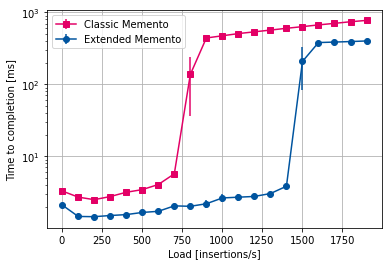

In [28]:
#request_count_noresponse = np.array(_['counts'][0])/(60*5) #TODO Make dynamic? corresonds to config.EXECUTION_TIME_PER_LOAD, instead use distance between first-last timestamp?
request_count_noresponse =  [element * 2 for element in LOADS]
success_insertions_noresponse = np.array(exp1['avg'][0])
error_bar_noresponse = np.array(exp1["avg_confidence"][0])


#request_count_extended = np.array(_['counts'][1])/(60*5) #TODO Make 10 dynamic? corresonds to config.EXECUTION_TIME_PER_LOAD
request_count_extended = [element * 2 for element in LOADS]
success_insertions_extended = np.array(exp1['avg'][1])
error_bar_extended = np.array(exp1["avg_confidence"][1])


fig, ax = plt.subplots()
plt.yscale('log')
h1 = ax.errorbar(request_count_noresponse, success_insertions_noresponse, yerr=error_bar_noresponse, marker="s", label="Classic Memento", color="#e30066")
h2 = ax.errorbar(request_count_extended, success_insertions_extended, yerr=error_bar_extended, marker="o", label="Extended Memento", color="#00549F")


#plt.ylim(0,1000)
ax.set(xlabel='Load [insertions/s]', ylabel='Time to completion [ms]')

ax.grid()
ax.legend(loc=2)

plt.show()



## Plot error for different loads on a single resource

An insertion is only considered successful, if the server assigns a unique identifier for the inserted resource revision
and the client learns the correct identifier so it can reference to the associated resource revision.

In the case of classic Memento, due to the limited timestamp resoultion, only a single revision gets a unique identifier per second.
That limits the effective load on a single resource to 1 insertion/second, otherwise most of the insertions will not be uniquely identified.
If RFC3339 timestamps are used, but the associated timestamp is not returned with the response to a POST or PUT request,
the client must issue a subsequent GET request to learn the exact timestamp.
However, between the POST request and the GET request, another insertion may have taken place on the same resource.
In that case, the client learns a timestamp associated with the wrong resource revision.
This is increasingly likely for high loads on a single resource.
The client checks if the correct timestamp was returned by comparing the inserted resource content with the returned content.
If the contents match, the insertion is considered successful otherwise the insertion failed.
For the extended Memento protocol, the timestamp associated with an insertion can be learned directly from the response to a POST or PUT request and a subsequent GET request is not necessary.
The percentages for the classic Memento protocol are not measured, but a best-case estimation, based on the availability of timestamps and the pigeon-hole principle.
If a cerain timestamp is not used, due to timing, the resulting number of successful insertions may be worse.

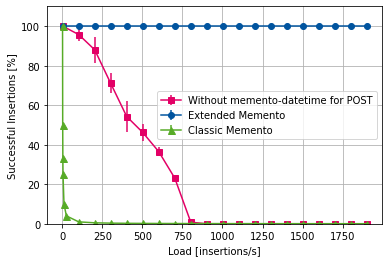

In [27]:
request_count_classic = [element * 2 for element in LOADS]
request_count_classic.pop(0)
request_count_classic = list(np.arange(1.0, 5, 1)) + [10,25] + request_count_classic
success_insertions_classic = np.float_power(request_count_classic, -1)*100

#request_count_noresponse = np.array(_['counts'][0])/(60*5) #TODO Make 10 dynamic? corresonds to config.EXECUTION_TIME_PER_LOAD
request_count_noresponse = [element * 2 for element in LOADS]
success_insertions_noresponse = np.array(exp1['successful_insertions'][0])
error_bar_noresponse = np.array(exp1["successful_insertions_confidence"][0])
error_bars_noresponse = [np.copy(error_bar_noresponse), np.copy(error_bar_noresponse)]
for i in range(len(error_bar_noresponse)):
    if success_insertions_noresponse[i] + error_bar_noresponse[i] > 100:
        error_bars_noresponse[1][i] = 100 - success_insertions_noresponse[i]
    if success_insertions_noresponse[i] - error_bar_noresponse[i] < 0:
        error_bars_noresponse[0][i] = success_insertions_noresponse[i]

#request_count_extended = np.array(_['counts'][1])/(60*5) #TODO Make 10 dynamic? corresonds to config.EXECUTION_TIME_PER_LOAD
request_count_extended = [element * 2 for element in LOADS]
success_insertions_extended = np.array(exp1['successful_insertions'][1])
error_bar_extended = np.array(exp1["successful_insertions_confidence"][1])

error_bar_placeholder = np.zeros(success_insertions_classic.size)

fig, ax = plt.subplots()

h1 = ax.errorbar(request_count_noresponse, success_insertions_noresponse, yerr=error_bars_noresponse, marker="s", label="Without memento-datetime for POST", color="#e30066")
h2 = ax.errorbar(request_count_extended, success_insertions_extended, yerr=error_bar_extended, marker="o", label="Extended Memento", color="#00549F")

h3 = ax.errorbar(request_count_classic, success_insertions_classic, yerr=error_bar_placeholder, marker="^", markersize=7, label="Classic Memento", color="#57ab27")

plt.ylim(0,110)
ax.set(xlabel='Load [insertions/s]', ylabel='Successful Insertions [%]')

ax.grid()
ax.legend(loc=0)

plt.show()